In [1]:
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import defaultdict


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Aser\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Aser\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "c:\Users\Aser\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", lin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Aser\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Aser\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "c:\Users\Aser\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", lin

AttributeError: _ARRAY_API not found

In [2]:
# Load dataset (assuming it has 'user_id' and 'book_id' columns)
df = pd.read_csv("df_fiction.csv")

In [3]:
df.head()

,Title,authors,categories,Id,User_id,profileName,review/helpfulness,review/score,review/text
0,Tess and the Highlander,['May Mcgoldrick'],['Juvenile Fiction'],006000486X,A2VCGJLKGK2WJJ,Rebecca Herman,17/18,5.0,Tess was washed ashore on the Isle of May duri...
1,Tess and the Highlander,['May Mcgoldrick'],['Juvenile Fiction'],006000486X,AVWFMN5CELC8Q,sarah,6/6,4.0,This is an engaging a count of life of Tess a ...
2,Tess and the Highlander,['May Mcgoldrick'],['Juvenile Fiction'],006000486X,A37XYM3KSEIDLS,"jaina_solo ""jaina_solo""",6/6,5.0,This book was a perfect historical romance for...
3,Tess and the Highlander,['May Mcgoldrick'],['Juvenile Fiction'],006000486X,A1IQK80SXVPAWW,atlantis_girl,4/4,5.0,I loved everything about this book - the setti...
4,Tess and the Highlander,['May Mcgoldrick'],['Juvenile Fiction'],006000486X,A1PI0GN5N7M3GF,Patricia Ahern,5/6,5.0,This book was spellbinding! Filled with advent...


In [4]:
# Remove users who reviewed only one book (no connections possible)
user_review_counts = df['User_id'].value_counts()
df_filtered = df[df['User_id'].isin(user_review_counts[user_review_counts > 1].index)]

In [5]:
# Group by user_id and create a dictionary of books reviewed per user
user_books = df_filtered.groupby("User_id")["Title"].apply(list).to_dict()

In [6]:
# Create an undirected graph
G = nx.Graph()

# Add edges between books reviewed by the same users
for books in user_books.values():
    for book1, book2 in combinations(set(books), 2):  # Set to remove duplicates
        if G.has_edge(book1, book2):
            G[book1][book2]['weight'] += 1  # Increase weight if already connected
        else:
            G.add_edge(book1, book2, weight=1)

In [7]:
print(f"Graph created with {len(G.nodes)} books and {len(G.edges)} connections.")

Graph created with 3991 books and 134564 connections.


In [8]:
# Compute PageRank
pagerank_scores = nx.pagerank(G, weight="weight")

# Convert to DataFrame
pagerank_df = pd.DataFrame(pagerank_scores.items(), columns=["book_id", "pagerank"])
pagerank_df = pagerank_df.sort_values(by="pagerank", ascending=False)

# Display top-ranked books
print(pagerank_df.head(10))

                                               book_id  pagerank
5                Harry Potter and The Sorcerer's Stone  0.008942
33                                          The Hobbit  0.005532
51             Harry Potter and the Chamber of Secrets  0.005512
117                                          The Giver  0.004973
21                                               Holes  0.004780
70                                      Goodnight Moon  0.003627
199                          Where The Wild Things Are  0.003338
200                                 Tale of Despereaux  0.003177
3    The witch of blackbird pond (A Dell yearling b...  0.002916
4            The witch of Blackbird Pond (A Dell book)  0.002916


## filtering hidden gems

In [9]:
# Find total review count per book
book_review_counts = df_filtered['Id'].value_counts()

# Define threshold: remove books in the top 10% of reviews
threshold = book_review_counts.quantile(0.95)
filtered_books = book_review_counts[book_review_counts < threshold].index

# Filter dataset
df_filtered_hidden_gems = df_filtered[df_filtered['Id'].isin(filtered_books)]


In [10]:

# Rebuild graph with only "hidden gem" books
G_hidden = nx.Graph()

user_books_hidden = df_filtered_hidden_gems.groupby("User_id")["Title"].apply(list).to_dict()
for books in user_books_hidden.values():
    for book1, book2 in combinations(set(books), 2): 
        if G_hidden.has_edge(book1, book2):
            G_hidden[book1][book2]['weight'] += 1
        else:
            G_hidden.add_edge(book1, book2, weight=1)

# Run PageRank again
pagerank_hidden = nx.pagerank(G_hidden, weight="weight")

# Convert to DataFrame
pagerank_hidden_df = pd.DataFrame(pagerank_hidden.items(), columns=["Title", "pagerank"])
pagerank_hidden_df = pagerank_hidden_df.sort_values(by="pagerank", ascending=False)

# Display top "hidden gem" books
print("Hidden Gems by PageRank:\n", pagerank_hidden_df.head(10))

Hidden Gems by PageRank:
                                              Title  pagerank
276            Bunnicula: A rabbit tale of mystery  0.001740
860                                   CHARMED LIFE  0.001683
418                               Casey at the Bat  0.001623
213                              The Matchlock Gun  0.001614
482                      CORNER OF THE UNIVERSE, A  0.001606
206                               Snowmen at Night  0.001570
217  How to eat fried worms (A Dell yearling book)  0.001558
268            The Red Book (Caldecott Honor Book)  0.001520
219       The Tale of Peter Rabbit (Read and Hear)  0.001509
394                                  Noah's Castle  0.001497


## Visualisation

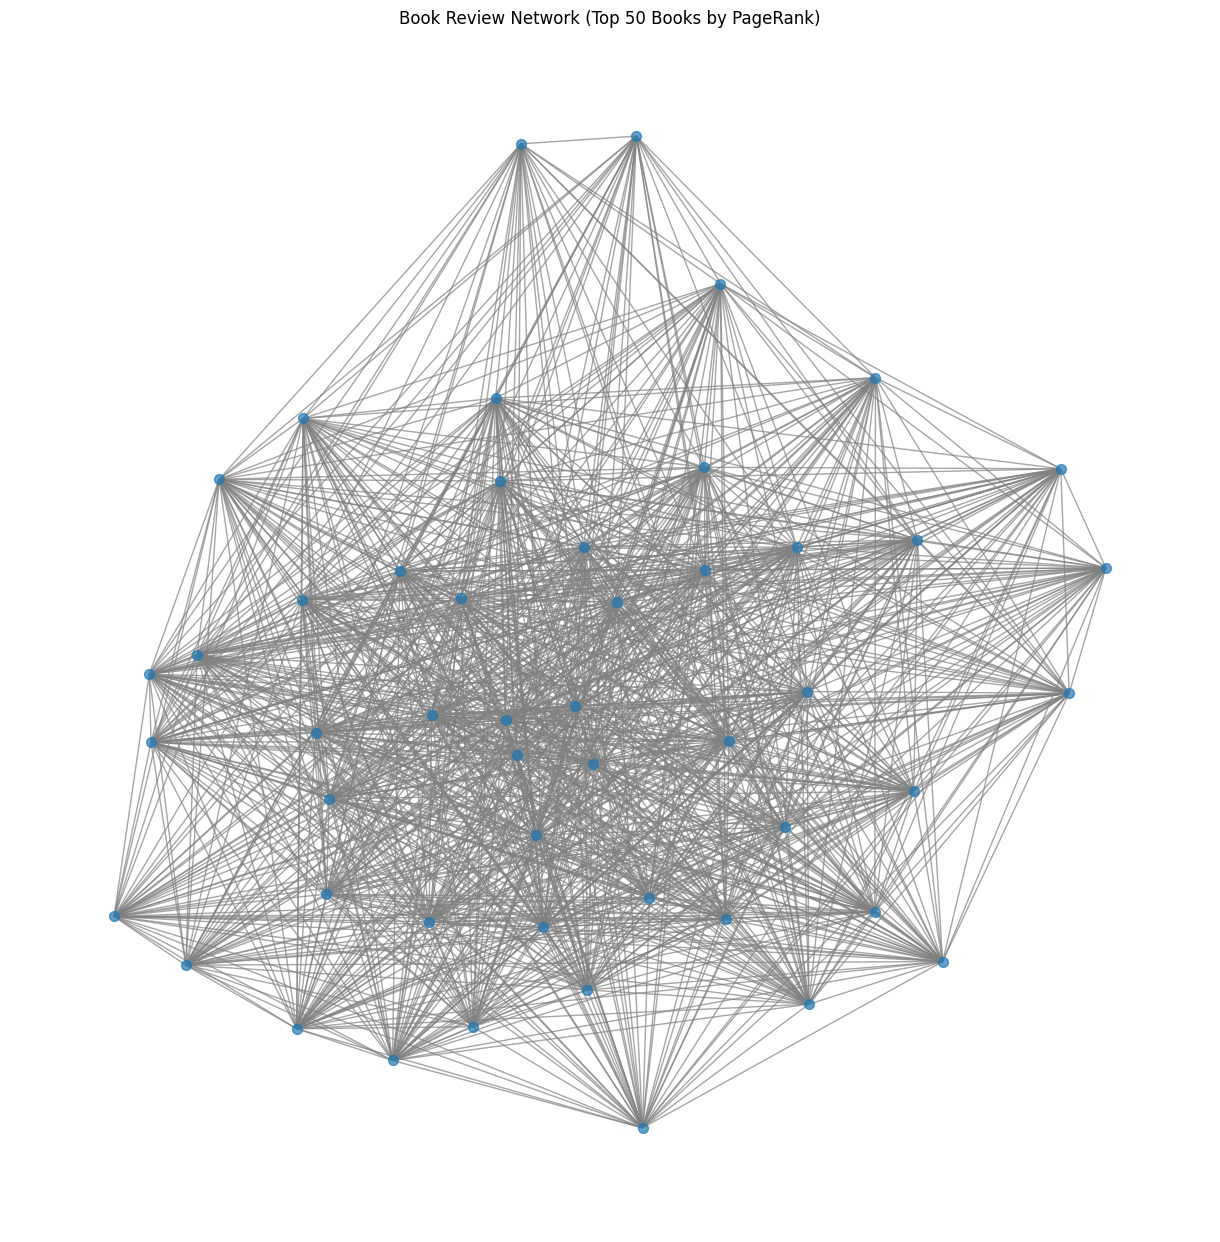

In [11]:
import matplotlib.pyplot as plt

# Extract top 50 influential books
top_books = set(pagerank_df.head(50)['book_id'])

# Create subgraph
G_sub = G.subgraph(top_books)

# Plot network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_sub, seed=42)  # Position nodes
nx.draw(G_sub, pos, with_labels=False, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Book Review Network (Top 50 Books by PageRank)")
plt.show()